#### Extract patches from data_processedv2 and make data_processedvpl with subfolder named train and val with images and masks folder using sliding window technique

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import os
import skimage.draw
import numpy as np
from tqdm import tqdm
import cv2
import random

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')



def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)
        
        
label_map = {'Epithelial':1,
             'Lymphocyte':2,
             'Macrophage':4,
             'Neutrophil':3,
            }

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Directory of images to run sliding window on
TRAIN_IMAGES =  os.path.join(ROOT_DIR, "dataset", "data_processedv2", "train", "images/")
TRAIN_MASKS = os.path.join(ROOT_DIR, "dataset", "data_processedv2", "train", "masks/")

VAL_IMAGES =  os.path.join(ROOT_DIR, "dataset", "data_processedv2", "val", "images/")
VAL_MASKS = os.path.join(ROOT_DIR, "dataset", "data_processedv2", "val", "masks/")

# Make new folders
TRAIN_IMAGES_DEST =  os.path.join(ROOT_DIR, "dataset", "data_processedvpl", "train", "images/")
TRAIN_MASKS_DEST = os.path.join(ROOT_DIR, "dataset", "data_processedvpl", "train", "masks/")

VAL_IMAGES_DEST =  os.path.join(ROOT_DIR, "dataset", "data_processedvpl", "val", "images/")
VAL_MASKS_DEST = os.path.join(ROOT_DIR, "dataset", "data_processedvpl", "val", "masks/")


# Create folders
create_directory(TRAIN_IMAGES_DEST)
create_directory(TRAIN_MASKS_DEST)
create_directory(VAL_IMAGES_DEST)
create_directory(VAL_MASKS_DEST)

In [3]:
#try:
#  # %tensorflow_version only exists in Colab.
#  %tensorflow_version 2.x
#except Exception:
#  pass

In [6]:
def pad(im, desired_size = 900):
    
    """
    Pad input image.
    Args:
        im (np.array): Input image numpy array
    Returns:
        new_im: Padded image array
    """
    
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    
    return new_im


def read_nuclei(path):
    "read raw data"

    # Load 4-channel image
    img = skimage.io.imread(path)
    
    # input image
    if len(img.shape) > 2:
        img = img[:,:,:3]
    # mask
    else:
        # do nothing
        pass
        
    return img



def save_nuclei(path, img):
    "save image"
    skimage.io.imsave(path, img)

    
def sliding_window(image, step, window):
    x_loc = []
    y_loc = []
    cells = []
    
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            cells.append(image[y:y + window[1], x:x + window[0]])
            x_loc.append(x)
            y_loc.append(y)
    return x_loc, y_loc, cells


def extract_patches(image, step, patch_size):
    
    patches = []
    
    # Get locations
    x_pos, y_pos, cells = sliding_window(image, step, (patch_size[0], patch_size[1]))

    for (x, y, cell) in zip(x_pos, y_pos, cells):

        # Get patch
        patch = image[y:y + 64, x:x + 64]

        # Get size
        raw_dim = (patch.shape[1], patch.shape[0]) # W, H
        #print(raw_dim)
        #print(patch.shape)


        if raw_dim != (64, 64):

            # Resize to 64x64
            patch = cv2.resize(patch, (64, 64), interpolation = cv2.INTER_AREA)

            # Do stuffffff
            patches.append(patch)
        
        else:

            # Do stuffffff
            patches.append(patch)
    
    patches = np.array(patches)
    
    return patches

Index:  153
(1310, 951, 3) (1310, 951)
Ground truth classes:  [0 1 2]


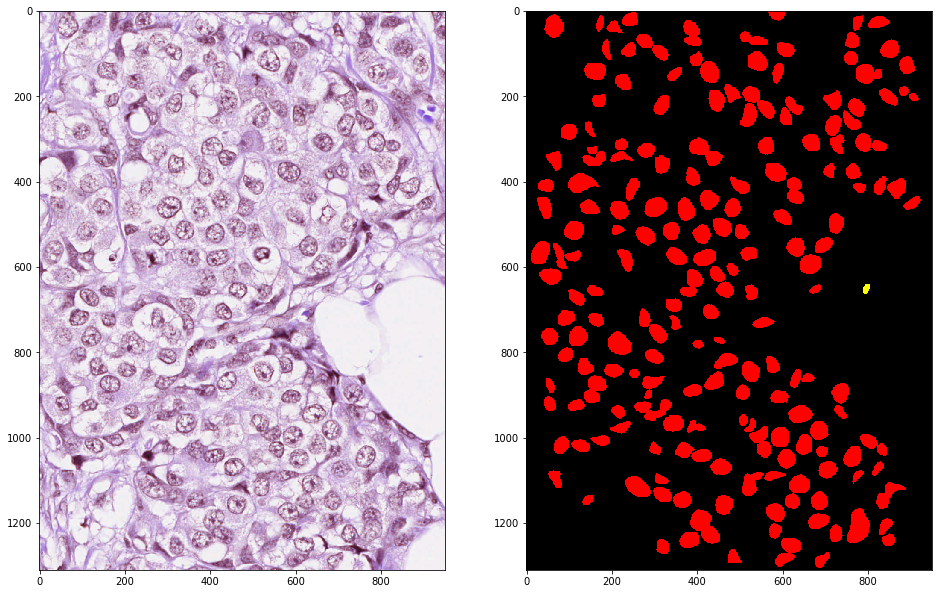

In [14]:
# Load a random image from the images folder
image_fns = sorted(next(os.walk(TRAIN_IMAGES))[2])
gt_fns = sorted(next(os.walk(TRAIN_MASKS))[2])


idx = random.randrange(len(image_fns)) # 94 
print("Index: ", idx)


image = skimage.io.imread(os.path.join(TRAIN_IMAGES, image_fns[idx]))
gt = skimage.io.imread(os.path.join(TRAIN_MASKS, gt_fns[idx]))

assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
assert image.dtype == gt.dtype, "Wrong data types!"

print(image.shape, gt.shape)

val1 = gt.flatten()
print("Ground truth classes: ", np.unique(val1))

#label_map = {'Epithelial':1,
#             'Lymphocyte':2,
#             'Macrophage':4,
#             'Neutrophil':3,
#            }

# Stolen from https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale 
norm=plt.Normalize(0,4) # 5 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])
#map_name = 'magma'

f, axarr = plt.subplots(1,2, figsize=(16,16))

# idx = 94 all classes
axarr[0].imshow(image, cmap=map_name, norm=norm)
axarr[1].imshow(gt, cmap=map_name, norm=norm)

#### Extract patches from a single image and mask

In [16]:
img_patches = None
gt_patches = None

patch_size = (64, 64)
step = 32  
img_patches = extract_patches(image, step, patch_size)
gt_patches = extract_patches(gt, step, patch_size)

print('Patches shape: {}, {}'.format(img_patches.shape, gt_patches.shape))

Patches shape: (1230, 64, 64, 3), (1230, 64, 64)


Patch mask mean: 0.07861328125
Patch mask mean: 0.62060546875
Patch mask mean: 0.191162109375
Patch mask mean: 0.0
Patch mask mean: 0.43798828125
Patch mask mean: 0.321533203125
Patch mask mean: 0.27001953125
Patch mask mean: 0.076171875
Patch mask mean: 0.433837890625
Patch mask mean: 0.25634765625


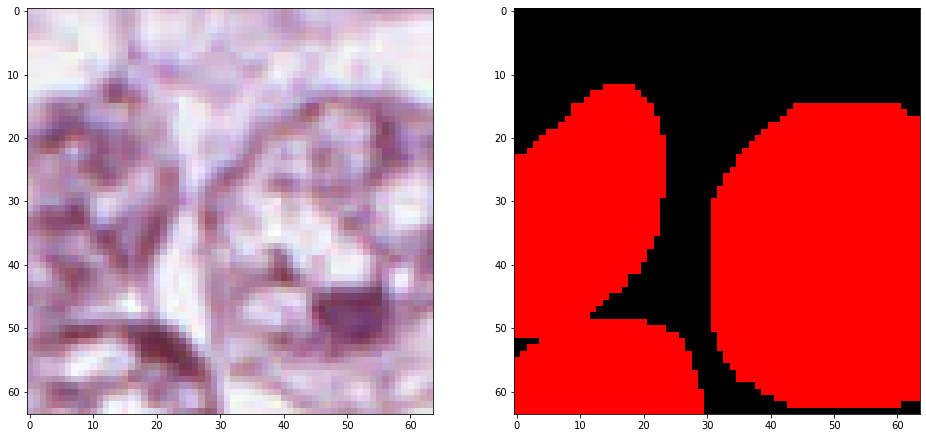

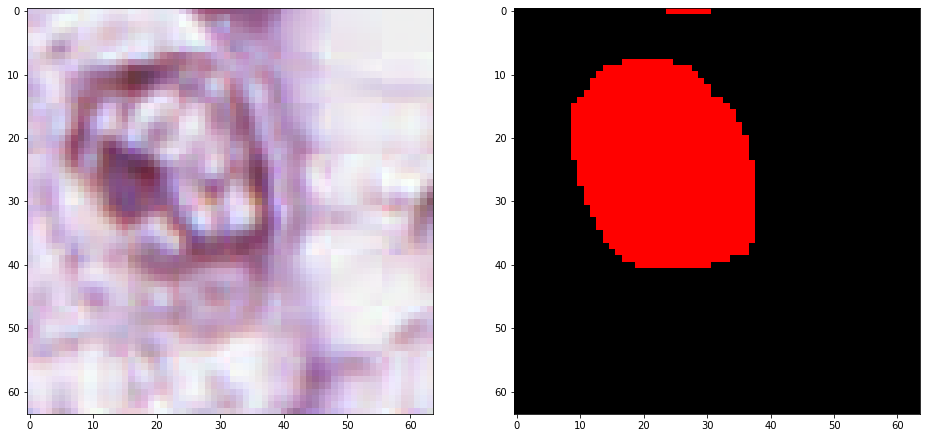

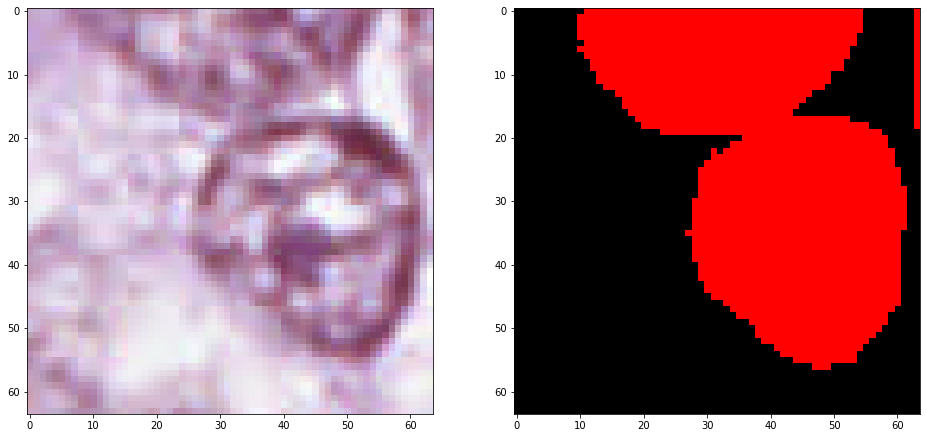

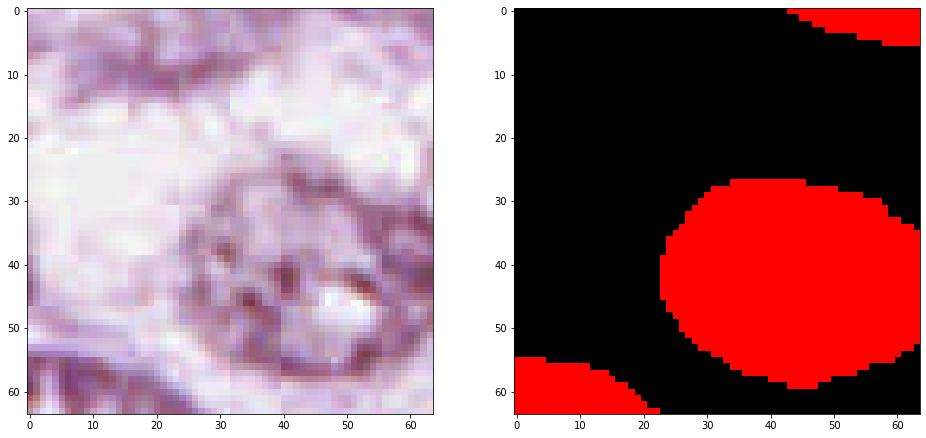

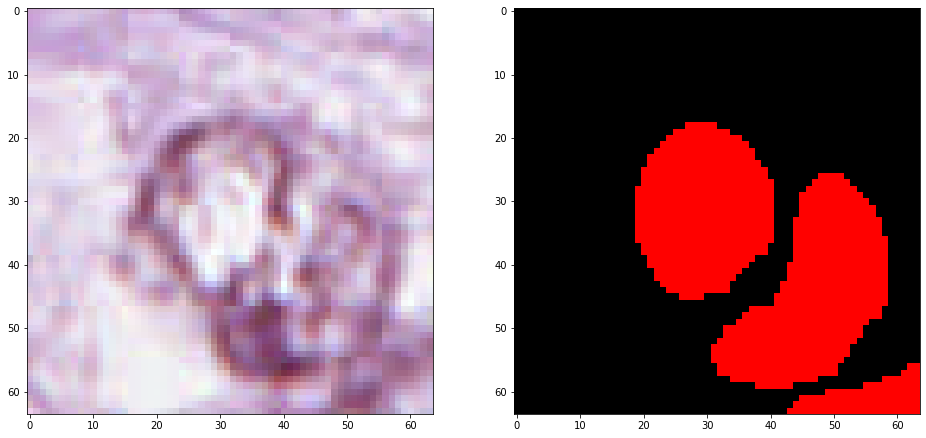

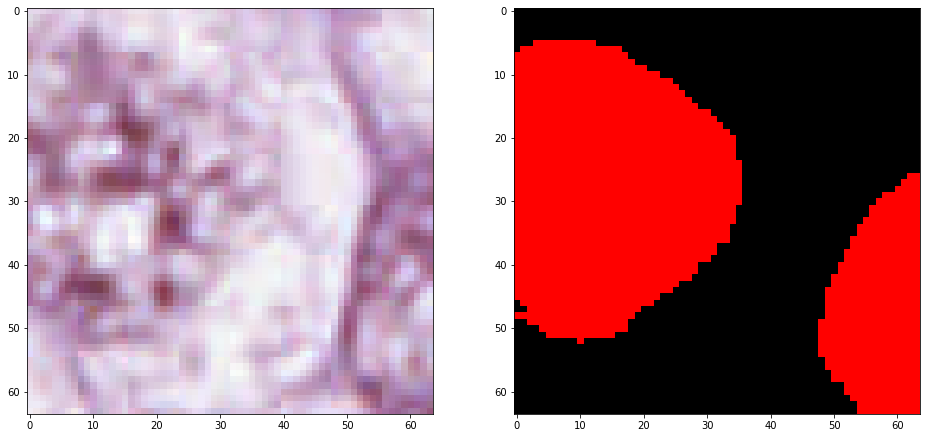

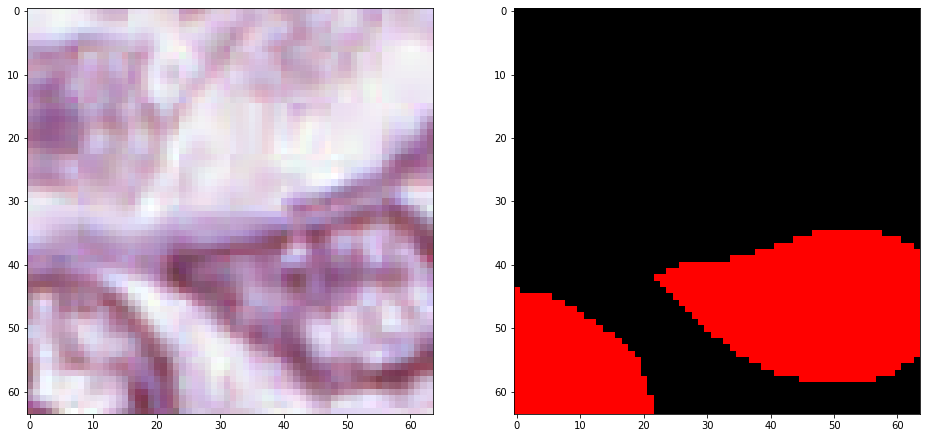

In [17]:
# Sanity check

def process(image, mask):
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    axarr[0].imshow(image, cmap=map_name, norm=norm)
    axarr[1].imshow(mask, cmap=map_name, norm=norm)

    
    
idxs = [random.randrange(len(img_patches)) for x in range(10)] 
for img, msk in zip(img_patches[idxs], gt_patches[idxs]):
    print("Patch mask mean:", np.mean(msk))
    
    # Set threshold for mask
    if np.mean(msk) < 0.099:
        pass
    
    else:
        process(img, msk)

#### Extract patches and save

In [18]:
train_image_fns = sorted(next(os.walk(TRAIN_IMAGES))[2])
train_gt_fns = sorted(next(os.walk(TRAIN_MASKS))[2])
train_image_fns[:3], train_gt_fns[:3]

(['0.png', '1.png', '10.png'], ['0.png', '1.png', '10.png'])

In [20]:
val_image_fns = sorted(next(os.walk(VAL_IMAGES))[2])
val_gt_fns = sorted(next(os.walk(VAL_MASKS))[2])
val_image_fns[:3], val_gt_fns[:3]

(['101.png', '112.png', '122.png'], ['101.png', '112.png', '122.png'])

In [21]:
# Patch size and stride step
patch_size = (64, 64)
step = 32

# Iterate over all image and masks in training set
ct=0

for img_path, gt_path in tqdm(zip(train_image_fns[:], train_gt_fns[:])):
    
    #print(img_path, gt_path)
    
    # Read image and ground truth
    image = skimage.io.imread(os.path.join(TRAIN_IMAGES, img_path))
    gt = skimage.io.imread(os.path.join(TRAIN_MASKS, gt_path))
    
    # Extract patches
    img_patches = extract_patches(image, step, patch_size)
    gt_patches = extract_patches(gt, step, patch_size)

    for im, msk in zip(img_patches, gt_patches):
        
        if np.mean(msk) < 0.099:
            pass
        
        else:
            # Save image patch 
            save_nuclei(TRAIN_IMAGES_DEST + "{}.png".format(ct), im)
            # Save mask patch
            save_nuclei(TRAIN_MASKS_DEST + "{}.png".format(ct), msk)
            ct+=1
        
    image = None
    gt = None
    img_patches = None
    gt_patches = None

167it [02:46,  1.00it/s]


In [22]:
# Do same for validation set

# Iterate over all image and masks in training set
ct=0

for img_path, gt_path in tqdm(zip(val_image_fns[:], val_gt_fns[:])):
    
    #print(img_path, gt_path)
    
    # Read image and ground truth
    image = skimage.io.imread(os.path.join(VAL_IMAGES, img_path))
    gt = skimage.io.imread(os.path.join(VAL_MASKS, gt_path))
    
    # Extract patches
    img_patches = extract_patches(image, step, patch_size)
    gt_patches = extract_patches(gt, step, patch_size)

    for im, msk in zip(img_patches, gt_patches):
        
        if np.mean(msk) < 0.099:
            pass
        
        else:
            # Save image patch 
            save_nuclei(VAL_IMAGES_DEST + "{}.png".format(ct), im)
            # Save mask patch
            save_nuclei(VAL_MASKS_DEST + "{}.png".format(ct), msk)
            ct+=1
        
    image = None
    gt = None
    img_patches = None
    gt_patches = None

42it [00:56,  1.35s/it]


### Check image-mask order

In [25]:
t_image_fns = sorted(next(os.walk(TRAIN_IMAGES_DEST))[2])
t_gt_fns = sorted(next(os.walk(TRAIN_MASKS_DEST))[2])

t_image_fns[:5], t_gt_fns[:5]

(['0.png', '1.png', '10.png', '100.png', '1000.png'],
 ['0.png', '1.png', '10.png', '100.png', '1000.png'])

In [26]:
v_image_fns = sorted(next(os.walk(VAL_IMAGES_DEST))[2])
v_gt_fns = sorted(next(os.walk(VAL_MASKS_DEST))[2])

v_image_fns[:5], v_gt_fns[:5]

(['0.png', '1.png', '10.png', '100.png', '1000.png'],
 ['0.png', '1.png', '10.png', '100.png', '1000.png'])

In [31]:
# Sanity check if images and gt match in data_processedv0

fc = 0
for x,y in tqdm(zip(t_image_fns, t_gt_fns)):
    image = skimage.io.imread(os.path.join(TRAIN_IMAGES_DEST, x))
    gt = skimage.io.imread(os.path.join(TRAIN_MASKS_DEST, y))
    #print(image.shape[:2], gt.shape)
    
    if image.shape[:2] == gt.shape:
        #print(True)
        pass
    else:
        fc+=1
        print(False)
        
print("False count :", fc)

46040it [00:48, 948.63it/s] 

False count : 0


In [32]:
# Sanity check if images and gt match in data_processedv0

fc = 0
for x,y in tqdm(zip(v_image_fns, v_gt_fns)):
    image = skimage.io.imread(os.path.join(VAL_IMAGES_DEST, x))
    gt = skimage.io.imread(os.path.join(VAL_MASKS_DEST, y))
    #print(image.shape[:2], gt.shape)
    
    if image.shape[:2] == gt.shape:
        #print(True)
        pass
    else:
        fc+=1
        print(False)
        
print("False count :", fc)

13657it [00:15, 861.67it/s]

False count : 0


### Display some image-masks in training set

[0 1]
[0 1]
[0 3]
[0 2]
[0 1]


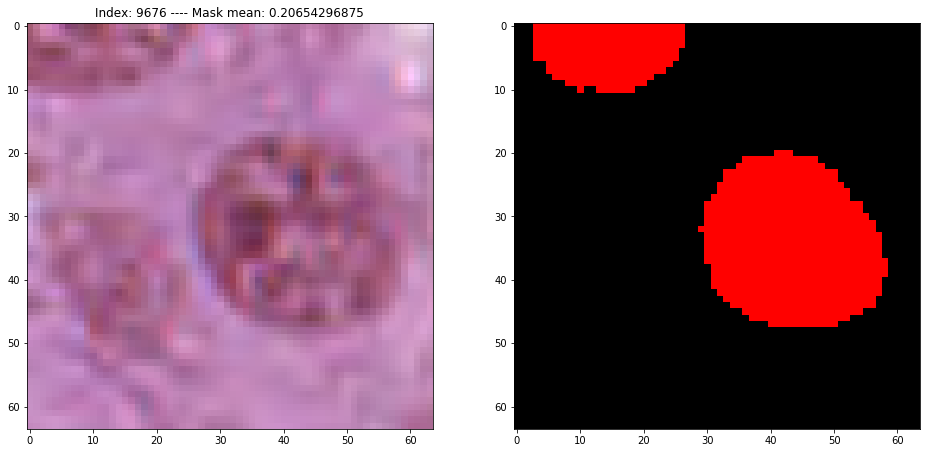

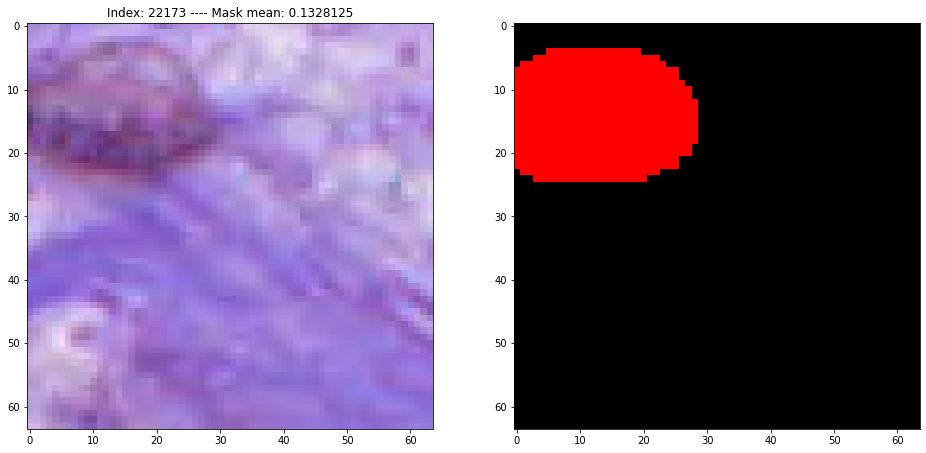

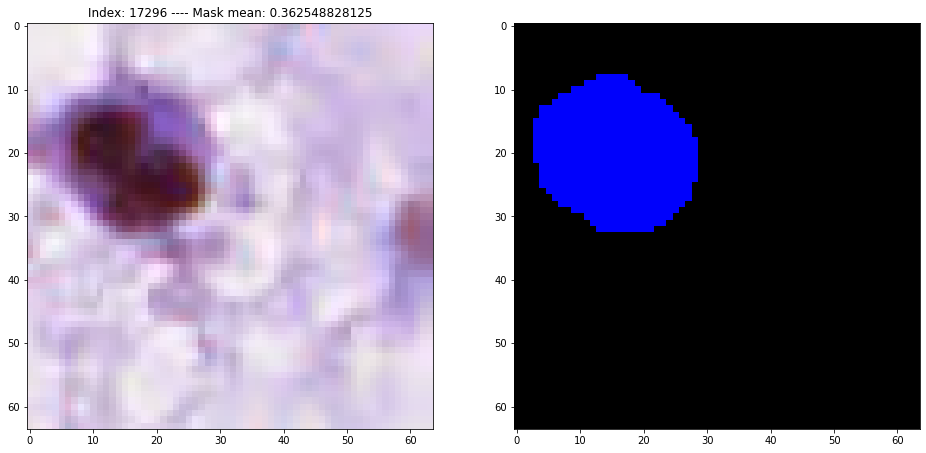

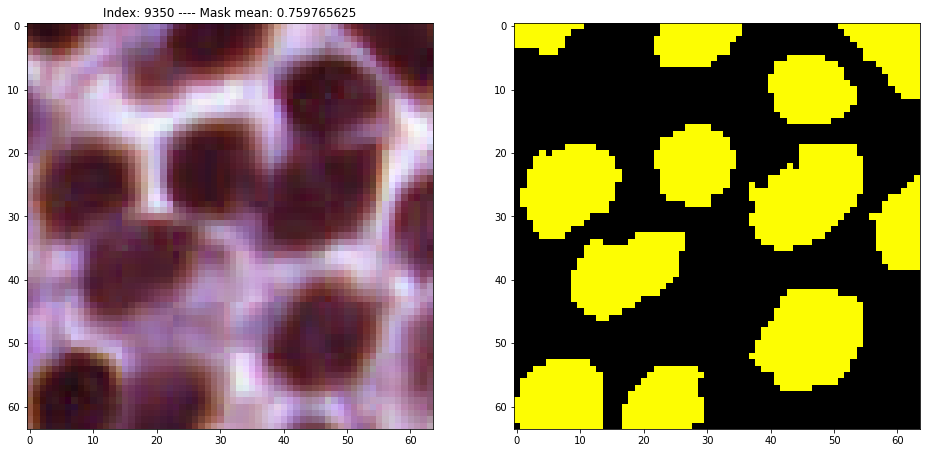

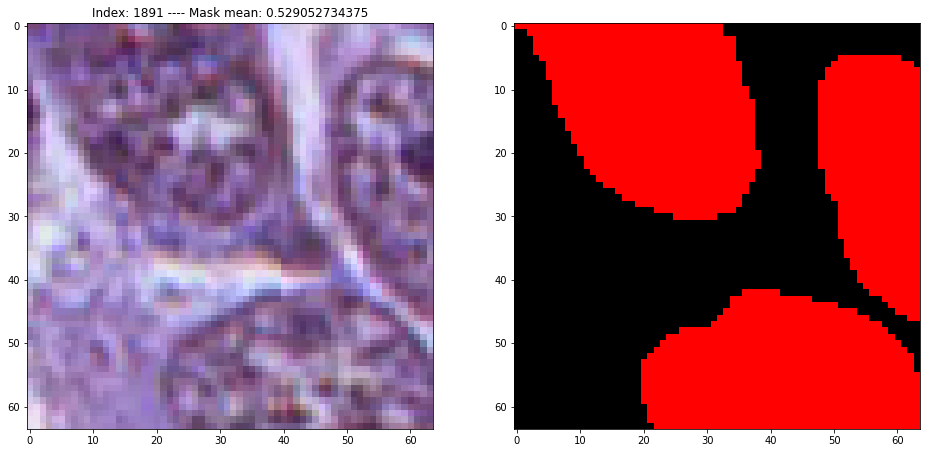

In [45]:
def process(image, mask, idx):
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    
    # Compute mean of mask
    axarr[0].set_title("Index: {} ---- Mask mean: {}".format(idx, np.mean(mask)))
    
    axarr[0].imshow(image, cmap=map_name, norm=norm)
    axarr[1].imshow(mask, cmap=map_name, norm=norm)

#label_map = {'Epithelial':1,
#             'Lymphocyte':2,
#             'Macrophage':4,
#             'Neutrophil':3,
#            }


count = 5
for i in range(count):
    
    idx = random.randrange(len(t_image_fns))
    
    image = skimage.io.imread(os.path.join(TRAIN_IMAGES_DEST, t_image_fns[idx]))
    gt = skimage.io.imread(os.path.join(TRAIN_MASKS_DEST, t_gt_fns[idx]))
    
    assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
    assert image.dtype == gt.dtype, "Wrong data types!"
    process(image, gt, idx)
    print(np.unique(gt))

[0 1 2]
[0 2]
[0 1]
[0 1 2]
[0 1]


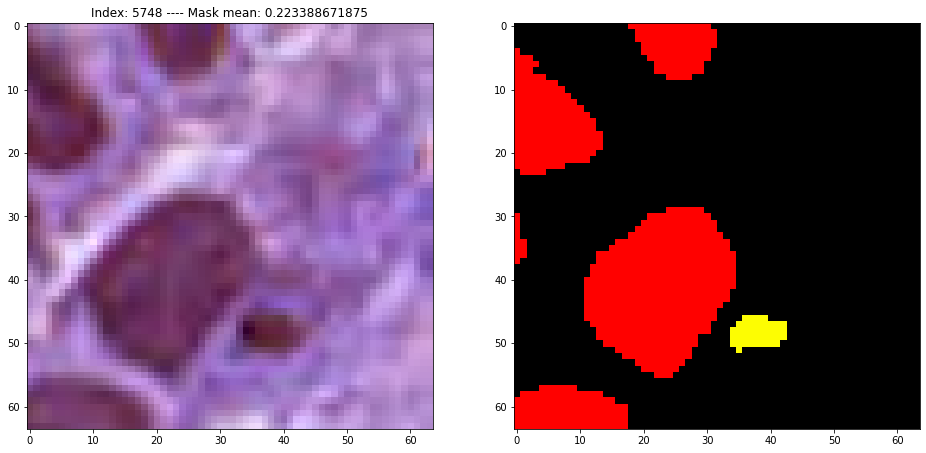

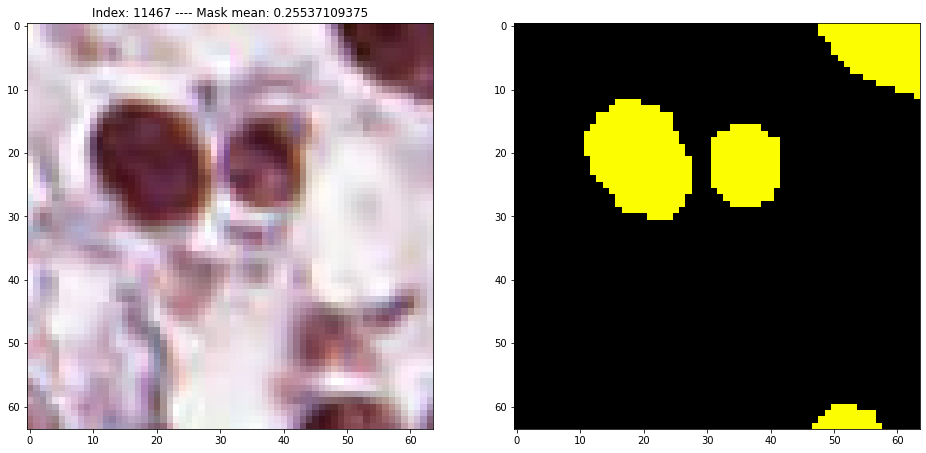

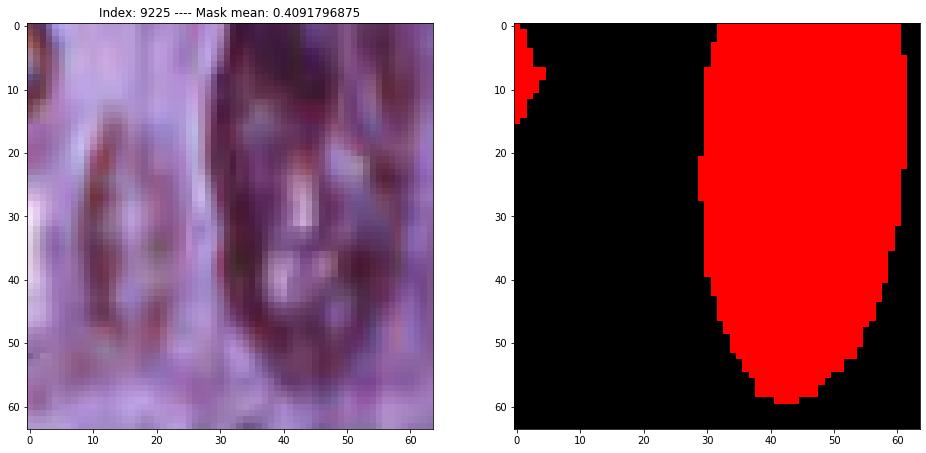

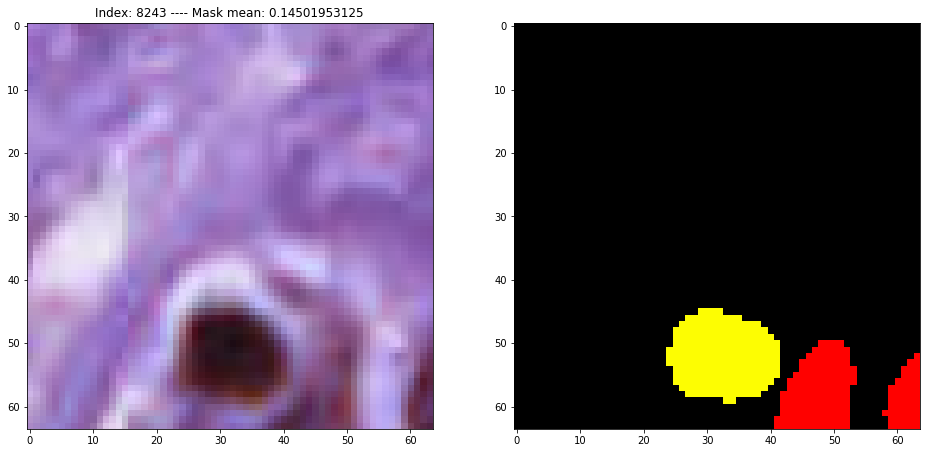

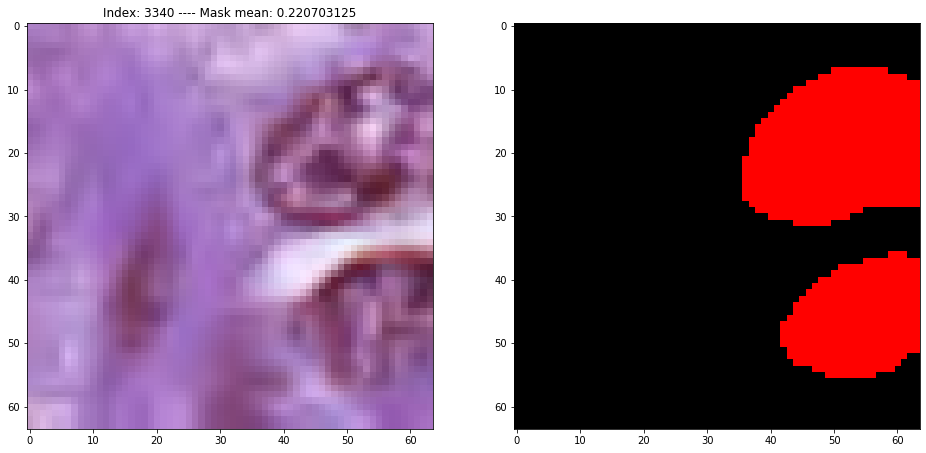

In [46]:
# From validation set

count = 5
for i in range(count):
    
    idx = random.randrange(len(v_image_fns))
    
    image = skimage.io.imread(os.path.join(VAL_IMAGES_DEST, v_image_fns[idx]))
    gt = skimage.io.imread(os.path.join(VAL_MASKS_DEST, v_gt_fns[idx]))
    
    assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
    assert image.dtype == gt.dtype, "Wrong data types!"
    process(image, gt, idx)
    print(np.unique(gt))